In [90]:
%matplotlib inline
#computation
import numpy as np
import pandas as pd
import os
#plotting
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style("ticks", {'axes.grid' : True})
pl.rc("figure", facecolor="white",figsize = (8,8))
pl.rc('lines',markeredgewidth = 2)
pl.rc('font',size = 24)

#notebook config
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import Math

from itertools import product
from scipy import special
from scipy.interpolate import griddata

fancy explore

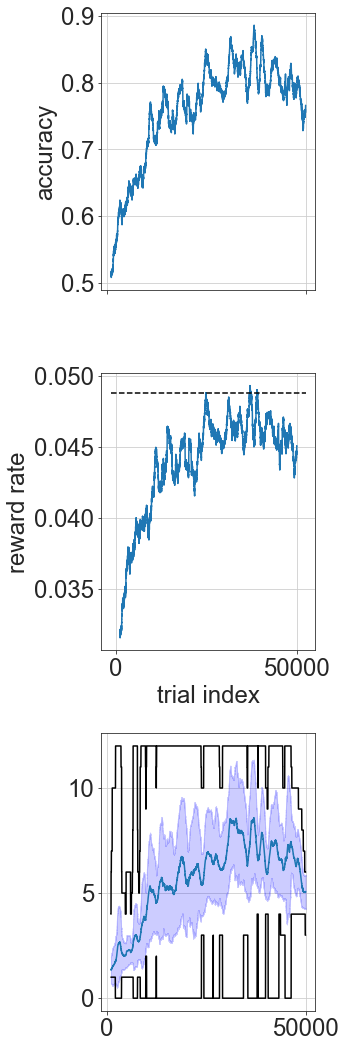

In [513]:
fig,ax=pl.subplots(3,1,figsize=(5,15))
dataroot='../storage/tokens-v0_reinforce_seed0_20-04-29-13-02-15'
dataset_name = os.path.basename(dataroot)
T=11

alpha=3.0/4

df_sarsa=pd.read_csv(dataroot+'/log.csv',sep=',')
# df_sarsa=df_sarsa[10000:]
df_sarsa.trajectory=df_sarsa.trajectory.apply(lambda row: np.asarray([int(x) for x in row[1:-1].split(', ')])) # tarjectory is string, turn it to numpy array
df_sarsa.rename(columns={'trajectory':'seq'},inplace=True)
df_sarsa.rename(columns={'choice_made':'nChoiceMade'},inplace=True)
df_sarsa.rename(columns={'correct_choice':'nCorrectChoice'},inplace=True)
df_sarsa.rename(columns={'decision_time':'tDecision'},inplace=True)
df_sarsa_copy = df_sarsa.copy()
df_sarsa.seq=df_sarsa.seq.apply(lambda row: np.diff(row)) # difference between consecutive elements, show we went left or right at each timestep
df_sarsa['reward']=(df_sarsa.nChoiceMade==df_sarsa.nCorrectChoice)
df_sarsa['reward_rate']=df_sarsa['reward']/(df_sarsa.tDecision+alpha*(T-df_sarsa.tDecision)+7.5)
# df_sarsa['reward_rate']=df_sarsa['reward_received']
df_sarsa.reward.rolling(window=1000).mean().plot.line(ax=ax[0])
df_sarsa.reward_rate.rolling(window=1000).mean().plot.line(ax=ax[1])
ax[1].plot(ax[1].get_xlim(),[(1/2)/(T/4+7.5)]*2,'k--')
df_sarsa.tDecision.rolling(window=1000).mean().plot.line(ax=ax[2])
me=df_sarsa.tDecision.rolling(window=1000).mean()
std=df_sarsa.tDecision.rolling(window=1000).std()
maxval=df_sarsa.tDecision.rolling(window=1000).max()
minval=df_sarsa.tDecision.rolling(window=1000).min()
ax[2].fill_between(range(len(me)), me - std, me + std,color='b', alpha=0.2)
ax[2].plot(minval,'k-')
ax[2].plot(maxval,'k-')
ax[0].set_xticklabels([])
# ax[1].plot([0,100000], 0.03724601256317603*np.ones((2,)),'k--')
# ax[0].plot([0,100000], 0.74*np.ones((2,)),'k--')
ax[1].set_xlabel('trial index')
ax[0].set_ylabel('accuracy')
ax[1].set_ylabel('reward rate')
fig.tight_layout()
fig.savefig('Info_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [514]:
# df_sarsa.loc[df_sarsa.tDecision == 0].tDecision = T
df_sarsa.head()

,seq,nChoiceMade,nCorrectChoice,tDecision,reward_received,reward,reward_rate
0,"[1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1]",1,1,2,0.063492,True,0.061538
1,"[1, 1, 1, -1, -1, -1, 1, 1, 1, 1, 1]",-1,1,1,0.063492,False,0.000000
2,"[-1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1]",-1,-1,1,0.000000,True,0.062500
3,"[1, -1, 1, 1, 1, 1, 1, -1, -1, 1, -1]",-1,1,1,0.000000,False,0.000000
4,"[1, 1, -1, -1, -1, -1, 1, -1, 1, -1, -1]",1,-1,1,0.063492,False,0.000000


In [515]:
df_sarsa_copy.head()

,seq,nChoiceMade,nCorrectChoice,tDecision,reward_received
0,"[0, 1, 2, 3, 4, 3, 4, 3, 4, 5, 4, 5]",1,1,2,0.063492
1,"[0, 1, 2, 3, 2, 1, 0, 1, 2, 3, 4, 5]",-1,1,1,0.063492
2,"[0, -1, 0, -1, 0, -1, 0, 1, 0, -1, 0, -1]",-1,-1,1,0.000000
3,"[0, 1, 0, 1, 2, 3, 4, 5, 4, 3, 4, 3]",-1,1,1,0.000000
4,"[0, 1, 2, 1, 0, -1, -2, -1, -2, -1, -2, -3]",1,-1,1,0.063492


some decisions at t=0!
<ipython-input-516-712045ffba4c>:113: RuntimeWarning: invalid value encountered in less
  z[z<0]=0
<ipython-input-516-712045ffba4c>:114: RuntimeWarning: invalid value encountered in greater
  z[z>1]=1


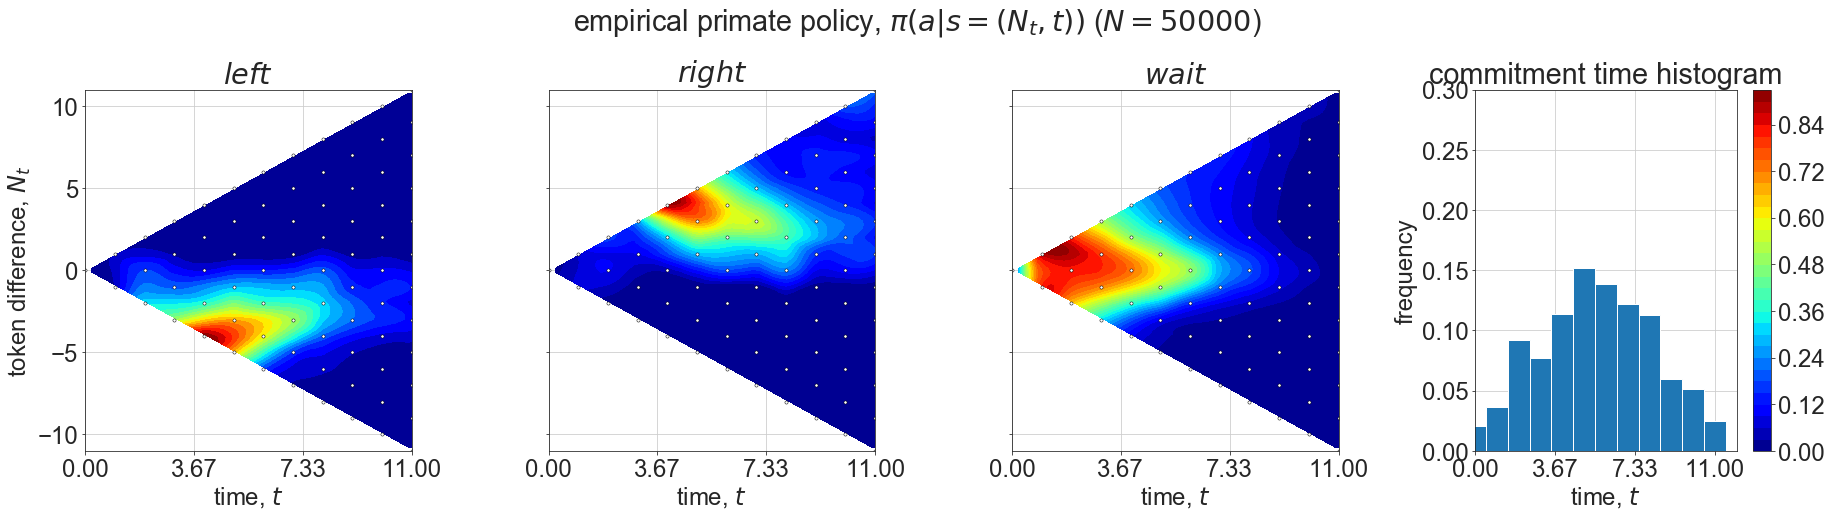

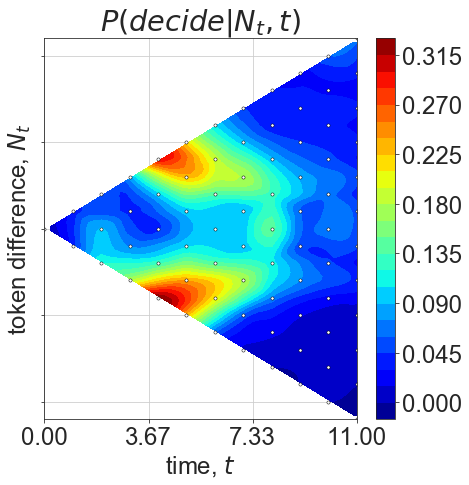

In [516]:
# plot_dec_times(df_sarsa.iloc[:].reset_index(),pl,'qlearn_fancybias_fancydiscount')
df_data = df_sarsa.iloc[:].reset_index()
ymax=0.3
# def plot_dec_times(df_data,pl,dataset_name,ymax=0.3,T=15):

'''
Computes empirical action policy distributions from a sample ensemble of trials held in the dataframe df_data 
'''

if (df_data.tDecision.values==0).sum():
    print('some decisions at t=0!')
    
###count distributions of decision events in (N_p,N_m) space 
dist=np.zeros((T+1,T+1))
dist_R=np.zeros((T+1,T+1))
dist_L=np.zeros((T+1,T+1))
dist_wait=np.zeros((T+1,T+1))
for it,tdec in enumerate(df_data.tDecision.values):
    curr_traj=df_data.seq.iloc[it]
    #over all trajs 
    dist[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,
    #over trajs|action
    if df_data.nChoiceMade.iloc[it]==1: # number of lefts and rights when agent chose right [ 1, -1, 1, -1, -1 ] => distR[2, 3] += 1 
        dist_R[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    else:# trial_dec[it]==-1:
        dist_L[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    for sit in range(1,int(tdec)): #add wait action up to decision,number [ 1, -1, 1, -1, -1 ] => dist_wait[1, 0] += 1, dist_wait[1, 1] += 1, dist_wait[2, 1] += 1, dist_wait[2, 2] += 1, dist_wait[3, 2] += 1
        dist_wait[np.sum(curr_traj[:sit-1]==1),np.sum(curr_traj[:sit-1]==-1)]+=1 #increment occupancy at given (Np,Nm)
#add t=0 data
dist[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade!=0)).sum()
dist_R[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==1)).sum()
dist_L[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade==-1)).sum()
dist_wait[0,0]=((df_data.tDecision==0) & (df_data.nChoiceMade !=-1) & (df_data.nChoiceMade !=1)).sum()
# print("Raw")
# print(dist)
# print(dist_R)
# print(dist_L)
# print(dist_wait)    


###state occupancy count distributions in (N_p,N_m) space
occupancy_dist=np.zeros((T+1,T+1))
Nt_samples=np.cumsum(np.asarray(df_data.seq.tolist()),axis=1) #reverse np.diff to create trajectory
# print("Nt_samples")
# print(Nt_samples)

    #note that this starts at t=1, so indexing adjusted by -1 below.
for Np in np.arange(T+1):
    for Nm in np.arange(T+1):
        if Np+Nm<=T and Np+Nm>0:#=0
            occupancy_dist[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)     
occupancy_dist[0,0]=len(df_data) #all trajs go through (N_p=0,N_m=0).
# print("Occ list")
# print(occupancy_dist)

# what does occupancy dist contain for [1,0]?
# the number of trajectories in which at timestep Np+Nm (1 + 0) the token is at location Np-Nm (1 - 0)
# [1,1], timestep 2, location 0
# [1, 14] timestep 15, location -13
# [2, 1] timestep 3, location 1
# [2, 13], timestep 15, location -11



###combine to form state frequency distributions
dist_tmp=np.zeros(dist.shape)
dist_R_tmp=np.zeros(dist_R.shape)
dist_L_tmp=np.zeros(dist_L.shape)
dist_wait_tmp=np.zeros(dist_L.shape)
for Np in range(T+1):
    for Nm in range(T+1):
        if occupancy_dist[Np,Nm]>0:
#             if dist[Np,Nm]>0:
            dist_tmp[Np,Nm]=dist[Np,Nm]/occupancy_dist[Np,Nm]
            # number of time we had Np left and Np right when we made a t_decision = Np+Nm
            # over number of times we had Np left and Np right at time step Np+Nm >= t_decision
            dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/occupancy_dist[Np,Nm] 
            dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/occupancy_dist[Np,Nm] 
            dist_wait_tmp[Np,Nm]= dist_wait[Np,Nm]/occupancy_dist[Np,Nm]  #1.0 - dist_tmp[Np,Nm] 
#                 dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/dist[Np,Nm] 
#                 dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/dist[Np,Nm] 
#                 dist_wait_tmp[Np,Nm]= dist_wait[Np,Nm]/dist[Np,Nm] 
dist=dist_tmp
dist_R=dist_R_tmp
dist_L=dist_L_tmp
dist_wait=dist_wait_tmp

# print("Normalized")
# print(dist)
# print(dist_R)
# print(dist_L)
# print(dist_wait)    

###plot on smoothed coordinates.
mesh=np.meshgrid(range(T+1),range(T+1))
Npvec=mesh[0].flatten()
Nmvec=mesh[1].flatten()
tvec=Npvec+Nmvec # timestep
Nvec=Npvec-Nmvec # position
tvecdense=np.linspace(min(tvec),max(tvec),100)
Nvecdense=np.linspace(min(Nvec),max(Nvec),100)
#normalize dist for [0,1] colorscale
z_d=griddata((tvec,Nvec),dist.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

z_R=griddata((tvec,Nvec),dist_R.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
z_L=griddata((tvec,Nvec),dist_L.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')
z_wait=griddata((tvec,Nvec),dist_wait.flatten(), (tvecdense[None,:],Nvecdense[:,None]),method='cubic')

fig, ax=pl.subplots(1,4,figsize=(26,7))
strp=['left','right','wait']
zvec=[z_R,z_L,z_wait] #wrong order here, because something above is in wrong order...
for p,z in enumerate(zvec):
    z[z<0]=0
    z[z>1]=1
    CS=ax[p].contourf(tvecdense,Nvecdense,z,30,cmap=pl.cm.jet)#,vmax=1., vmin=0.)
    if p==0:
        ax[p].set_ylabel(r'token difference, $N_t$')
    else:
        ax[p].set_yticklabels('')
    ax[p].set_xlim(0,T)
    ax[p].set_ylim(-T,T)
    ax[p].set_xticks([0,1/3*T,2/3*T,T])
    ax[p].set_xlabel(r'time, $t$')
    ax[p].set_title(r'$'+strp[p]+'$')
    for Np in range(T+1):
        for Nm in range(T+1):
            if Np+Nm< T+1:
                ax[p].scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
ax[2].figure.colorbar(CS)
#response time distirbutions
df_data.tDecision.hist(ax=ax[3],bins=np.arange(T+2)-0.5,density=True)
ax[3].set_ylabel('frequency')
ax[3].set_xlabel(r'time, $t$')
ax[3].set_xlim(0,T+1)
ax[3].set_xticks([0,1/3*T,2/3*T,T])
ax[3].set_title('commitment time histogram')
ax[3].set_ylim(0,ymax)

fig.tight_layout()
fig.suptitle(r'empirical primate policy, $\pi(a|s=(N_t,t))$ ($N='+str(len(df_data))+'$)',y=1.05)
fig.savefig('policy_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

#prob of deciding
fig, ax=pl.subplots(1,1,figsize=(7,7))
CS=ax.contourf(tvecdense,Nvecdense,z_d,30,cmap=pl.cm.jet)
ax.set_ylabel(r'token difference, $N_t$')
ax.set_yticklabels('')
ax.set_xlim(0,T)
ax.set_ylim(-T,T)
ax.set_xticks([0,1/3*T,2/3*T,T])
ax.set_xlabel(r'time, $t$')
ax.set_title(r'$P(decide|N_t,t)$')
for Np in range(T+1):
    for Nm in range(T+1):
        if Np+Nm< T+1:
            ax.scatter(Np+Nm,Np-Nm,s=10,facecolor='w',edgecolor='k',lw=0.5)
ax.figure.colorbar(CS)
fig.savefig('Pdec_'+dataset_name+'.pdf', transparent=True,bbox_inches="tight",dpi=300)

In [481]:
df_sarsa[df_sarsa.nChoiceMade == 0]

,seq,nChoiceMade,nCorrectChoice,tDecision,reward_received,reward,reward_rate


In [482]:
h2 = df_sarsa_copy.head(20)

In [441]:
h1

,seq,nChoiceMade,nCorrectChoice,tDecision,reward_received,reward,reward_rate
1674,"[1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1]",0,-1,0,0.0,False,0.0
3206,"[1, 1, -1, 1, -1, -1, -1, -1, 1, 1, 1]",0,1,0,0.0,False,0.0
5324,"[-1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1]",0,-1,0,0.0,False,0.0
8248,"[1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1]",0,1,0,0.0,False,0.0


In [442]:
h2

,seq,nChoiceMade,nCorrectChoice,tDecision,reward_received
10000,"[0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 3]",1,1,3,1
10001,"[0, 1, 2, 3, 4, 3, 2, 1, 0, -1, 0, 1]",1,1,3,1
10002,"[0, 1, 2, 3, 2, 1, 2, 3, 2, 3, 2, 3]",1,1,3,1
10003,"[0, -1, 0, -1, -2, -3, -2, -3, -2, -1, 0, -1]",-1,-1,5,1
10004,"[0, 1, 2, 1, 0, -1, -2, -1, -2, -3, -4, -3]",1,-1,2,0
10005,"[0, 1, 2, 1, 0, -1, -2, -3, -4, -5, -6, -7]",1,-1,3,0
10006,"[0, -1, -2, -3, -2, -1, 0, 1, 0, 1, 0, -1]",-1,-1,4,1
10007,"[0, 1, 2, 1, 0, -1, 0, 1, 0, -1, 0, -1]",1,-1,3,1
10008,"[0, -1, -2, -3, -4, -3, -4, -5, -4, -3, -2, -3]",-1,-1,4,0
10009,"[0, -1, -2, -1, 0, -1, -2, -3, -4, -3, -4, -3]",-1,-1,6,0


In [480]:
dist=np.zeros((T+1,T+1))
dist_R=np.zeros((T+1,T+1))
dist_L=np.zeros((T+1,T+1))
dist_wait=np.zeros((T+1,T+1))
for it,tdec in enumerate(h1.tDecision.values):
    curr_traj=h1.seq.iloc[it]
    #over all trajs 
    #problem if t_dec == 0
    dist[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm). int rounds down so should include current state. -1 to map to traj time index,
    #over trajs|action
    if h1.nChoiceMade.iloc[it]==1: # number of lefts and rights when agent chose right [ 1, -1, 1, -1, -1 ] => distR[2, 3] += 1 
        dist_R[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    else:# trial_dec[it]==-1:
        dist_L[np.sum(curr_traj[:int(tdec)]==1),np.sum(curr_traj[:int(tdec)]==-1)]+=1 #increment occupancy at given (Np,Nm)
    for sit in range(1,int(tdec)): #add wait action up to decision,number [ 1, -1, 1, -1, -1 ] => dist_wait[1, 0] += 1, dist_wait[1, 1] += 1, dist_wait[2, 1] += 1, dist_wait[2, 2] += 1, dist_wait[3, 2] += 1
        dist_wait[np.sum(curr_traj[:sit]==1),np.sum(curr_traj[:sit]==-1)]+=1 #increment occupancy at given (Np,Nm)
#add t=0 data
dist[0,0]=(h1.tDecision==0).sum() # how mant tajectories, when decision time was 0+0 and we had 0 left and 0 right in trajectory.
# how many trajectories with 0 right and 0 left up to dectsion time
# how many trajectories with 0 right and 0 left up to time 0+0
# how many trajectories at position 0 - 0 at time = 0 + 0 = decision time
# WE CANT HAVE CHOICE OF 0 or right and right won't add up to dist
dist_R[0,0]=((h1.tDecision==0) & (h1.nChoiceMade==1)).sum()
dist_L[0,0]=((h1.tDecision==0) & (h1.nChoiceMade==-1)).sum()
dist_wait[0,0]=((h1.tDecision==0) & (h1.nChoiceMade !=-1) & (h1.nChoiceMade !=1)).sum()
print("Raw")
print(dist)
print(dist_R)
print(dist_L)
print(dist_wait)

Raw
[[4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 

In [65]:
###state occupancy count distributions in (N_p,N_m) space
occupancy_dist=np.zeros((T+1,T+1))
Nt_samples=np.cumsum(np.asarray(h1.seq.tolist()),axis=1) #reverse np.diff to create trajectory
print("Nt_samples")
print(Nt_samples)

    #note that this starts at t=1, so indexing adjusted by -1 below.
for Np in np.arange(T+1):
    for Nm in np.arange(T+1):
        if Np+Nm<=T and Np+Nm>0:#=0
            occupancy_dist[Np,Nm]=np.sum(Nt_samples[:,Np+Nm-1]==Np-Nm)     
            # how many trajectories at position Np - Nm at time = Np+Nm != or = decision time
occupancy_dist[0,0]=len(h1) #all trajs go through (N_p=0,N_m=0).
print("Occ list")
print(occupancy_dist)

Nt_samples
[[ 1  2  3  4  3  4  5  4  5  6  7  8  9 10  9]
 [-1  0 -1  0  1  2  3  4  3  2  3  2  3  4  3]
 [-1 -2 -1 -2 -1 -2 -3 -4 -3 -4 -5 -6 -7 -8 -7]
 [-1 -2 -1 -2 -1 -2 -1 -2 -1  0  1  0 -1 -2 -3]
 [-1 -2 -3 -2 -1 -2 -1 -2 -1  0 -1  0 -1  0 -1]
 [ 1  0  1  0  1  0  1  2  1  2  3  4  3  4  3]
 [ 1  0  1  0  1  2  3  4  5  6  7  8  7  8  7]
 [ 1  0  1  0 -1 -2 -1  0  1  2  3  2  3  2  1]
 [ 1  2  1  2  3  4  3  4  3  4  3  4  5  6  5]
 [ 1  0  1  2  3  4  3  2  3  2  3  2  1  0  1]
 [-1  0  1  0 -1  0  1  0  1  2  3  4  5  4  3]
 [-1  0 -1 -2 -3 -4 -5 -4 -3 -2 -1 -2 -3 -2 -1]
 [ 1  2  3  2  3  4  3  2  3  2  1  0 -1 -2 -3]
 [ 1  2  1  2  1  2  1  0 -1 -2 -1  0  1  2  1]
 [ 1  0 -1 -2 -3 -2 -1  0 -1  0 -1 -2 -1  0 -1]
 [-1  0  1  2  3  4  3  4  5  4  3  2  3  2  1]
 [-1 -2 -1 -2 -1 -2 -3 -2 -1  0  1  2  1  0 -1]
 [-1 -2 -1 -2 -1 -2 -3 -4 -3 -4 -5 -4 -3 -2 -3]
 [-1 -2 -3 -4 -3 -2 -3 -4 -5 -4 -5 -4 -3 -2 -3]
 [ 1  0 -1 -2 -3 -4 -3 -4 -3 -4 -3 -2 -1 -2 -3]]
Occ list
[[20. 10.  6.  2.  

In [66]:
###combine to form state frequency distributions
dist_tmp=np.zeros(dist.shape)
dist_R_tmp=np.zeros(dist_R.shape)
dist_L_tmp=np.zeros(dist_L.shape)
dist_wait_tmp=np.zeros(dist_L.shape)
for Np in range(T+1):
    for Nm in range(T+1):
        if occupancy_dist[Np,Nm]>0:
#             if dist[Np,Nm]>0:
            dist_tmp[Np,Nm]=dist[Np,Nm]/occupancy_dist[Np,Nm]
            # number of time we had Np left and Np right when we made a t_decision = Np+Nm
            # over number of times we had Np left and Np right at time step Np+Nm >= t_decision
            dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/occupancy_dist[Np,Nm] 
            dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/occupancy_dist[Np,Nm] 
            dist_wait_tmp[Np,Nm]=1.0 -dist_R_tmp[Np,Nm] - dist_L_tmp[Np,Nm]#dist_wait[Np,Nm]/occupancy_dist[Np,Nm]   
#                 dist_R_tmp[Np,Nm]=dist_R[Np,Nm]/dist[Np,Nm] 
#                 dist_L_tmp[Np,Nm]=dist_L[Np,Nm]/dist[Np,Nm] 
#                 dist_wait_tmp[Np,Nm]= dist_wait[Np,Nm]/dist[Np,Nm] 
dist=dist_tmp
dist_R=dist_R_tmp
dist_L=dist_L_tmp
dist_wait=dist_wait_tmp
print("Norm")
print(dist)
print(dist_R)
print(dist_L)
print(dist_wait)

Norm
[[0.02  0.225 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.6   0.1   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   ]
 [0.    0.    0